In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
from data_reader_writer import data_writer

import pypsa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## System Transformation - 2045

In [3]:
# scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
scenario = 'System Transformation'
# scenario = 'Steady Progression'
year = 2045
year_baseline = 2012

start = str(year) + '-01-01 00:00:00'
end = str(year) + '-12-31 23:30:00'
# time step as fraction of hour
time_step = 1
data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
            scenario=scenario, FES=2022, merge_generators=True, scale_to_peak=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:206: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Tidal lagoon S.W.Penisula', 'Tidal stream Deeside',
       'Tidal stream Lovedean', 'Tidal stream Melksham',
       'Tidal stream Penwortham', 'Tidal stream S.W.Penisula',
       'Wave power Beauly', 'Wave power Melksham', 'Wave power Neilston'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


8624.343092233565

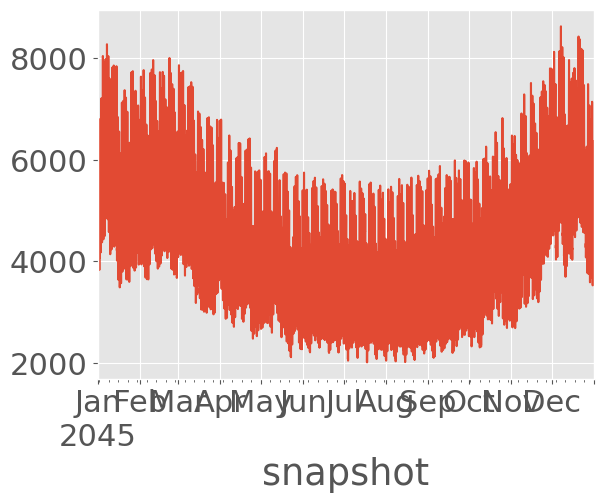

In [ ]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')
loads = network.loads_t.p_set
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
network.buses

89651.792060898

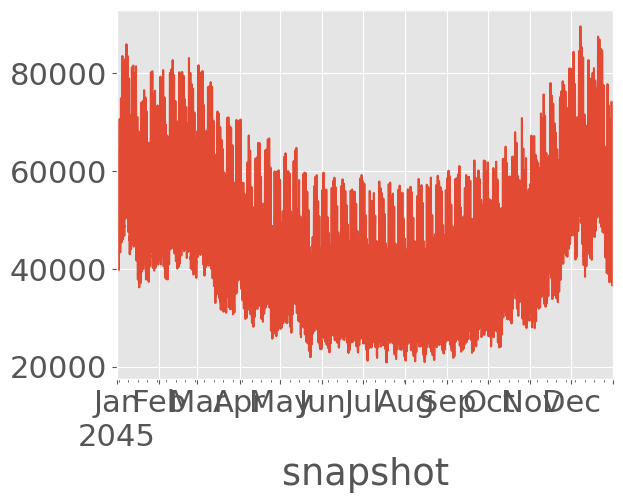

In [ ]:
# select generators in the buses in Scotland
# loads_scotland = 
loads.sum(axis=1).plot()
loads.sum(axis=1).max()

In [ ]:
contingency_factor = 40
network.lines.s_nom *= contingency_factor

In [ ]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 76.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-o876fezh.lp
Reading time = 55.09 seconds
obj: 23519744 rows, 7130641 columns, 41432997 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23519744 rows, 7130641 columns and 41432997 nonzeros
Model fingerprint: 0xbcaabf14
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 21680160 rows and 1284957 columns (presolve time = 6s) ...
Presolve removed 21680160 rows and 2526082 columns (presolve time = 18s) ...
Presolve removed 21684078 rows and 2530000 columns (presolve time = 20s) ...
Presolve removed 22170720 rows and 3016642 columns (presolve time = 28s) ...
Presolve removed 22170720 rows and 301664

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+09


('ok', 'optimal')

In [ ]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

print(network.links_t.p0)
imp = network.links_t.p0.copy()
imp[imp < 0] = 0
imp['Interconnectors Import'] = imp.sum(axis=1)
interconnector_import = imp[['Interconnectors Import']]
print(interconnector_import)

p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

exp = network.links_t.p0.copy()
exp[exp > 0] = 0
exp['Interconnectors Export'] = exp.sum(axis=1)
interconnector_export = exp[['Interconnectors Export']]
print(interconnector_export)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

Link                 BritNed  EastWest  Moyle  Nemo     IFA   IFA2     NSL  \
snapshot                                                                     
2045-01-01 00:00:00      0.0       0.0    0.0   0.0 -1980.0  990.0  1386.0   
2045-01-01 01:00:00      0.0       0.0    0.0   0.0   396.0  990.0  1386.0   
2045-01-01 02:00:00      0.0       0.0    0.0   0.0  -396.0 -990.0  1386.0   
2045-01-01 03:00:00      0.0       0.0    0.0   0.0   396.0  990.0  1386.0   
2045-01-01 04:00:00      0.0       0.0    0.0   0.0 -1980.0  990.0  1386.0   
...                      ...       ...    ...   ...     ...    ...     ...   
2045-12-31 19:00:00      0.0       0.0    0.0   0.0   396.0  990.0  1386.0   
2045-12-31 20:00:00      0.0       0.0    0.0   0.0   396.0  990.0  1386.0   
2045-12-31 21:00:00      0.0       0.0    0.0   0.0  -396.0 -990.0  1386.0   
2045-12-31 22:00:00      0.0       0.0    0.0   0.0   396.0  990.0  1386.0   
2045-12-31 23:00:00      0.0       0.0    0.0   0.0   396.0 -990

,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,Coal,Hydrogen,Hydro,Natural Gas,Nuclear,Oil,...,Waste,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,Pumped Storage Hydroelectric,Interconnectors Import,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2045-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,15.38914,45167.140487,2725.556688,797.786548,946.518266,470.652497,0.000000,4356.0,0.0
2045-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,13.99714,39319.465304,2319.213595,1959.094916,0.000000,0.000000,2012.000000,3762.0,0.0
2045-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,13.99714,39397.581643,4344.201519,0.000000,0.000000,0.000000,1308.319468,3762.0,0.0
2045-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,13.99714,39391.980440,4246.962629,108.730468,83.269306,0.000000,921.852759,3762.0,0.0
2045-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,13.99714,39349.977204,4575.342347,0.000000,0.000000,0.000000,0.000000,4356.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,227.168756,0.0,0.0,0.0,...,0.0,16.62686,58275.178767,6846.961246,2225.892869,479.857643,0.000000,0.000000,3762.0,0.0
2045-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,94.714510,0.0,0.0,0.0,...,0.0,16.62686,55722.458960,6383.749602,1360.299662,939.257276,269.556589,0.000000,3762.0,0.0
2045-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,192.377987,0.0,0.0,0.0,...,0.0,16.62686,49078.183570,7818.775812,859.021550,276.089656,233.674190,362.741379,3762.0,0.0


408.621947

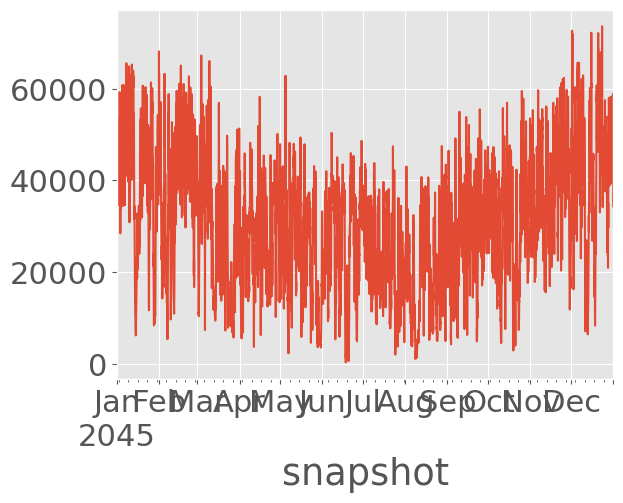

In [ ]:
p_by_carrier['Wind Offshore'].plot()
p_by_carrier['Wind Offshore'].min()

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

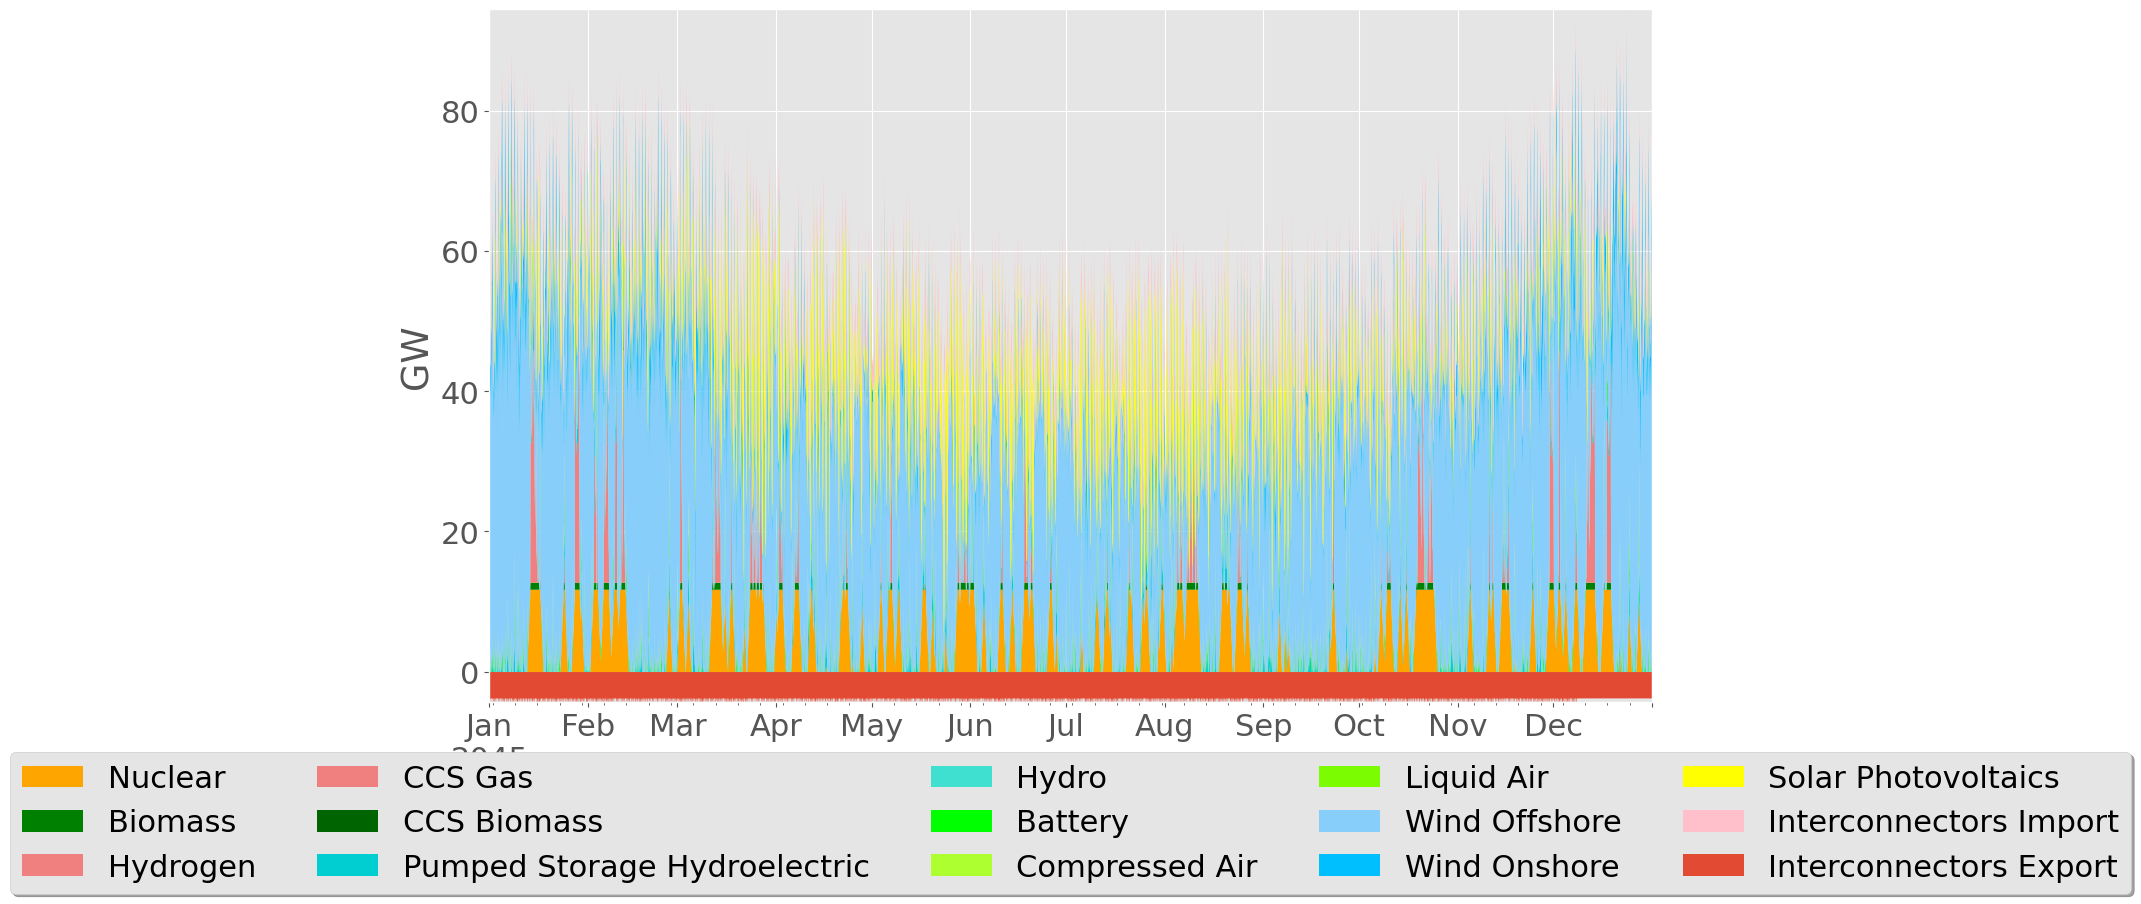

In [ ]:
cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import', 'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")